In [11]:
from dataset import *
from train import *
from utils import torch_fix_seed
import optuna
import sys
import logging

from sqlalchemy import create_engine

In [12]:
torch_fix_seed(19981303)
engine = create_engine("sqlite:///hyper_param_searching.db")

In [13]:
def get_self_pretrain_model(index=1000):
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    temp = torch.load(f'./checkpoints/ImageNet_ALL_CHECK_{index}_Epoch.pth')['state_dict']
    state_dict = {}
    for k, v in temp.items():
        if 'encoder_q' in k:
            if 'fc' not in k:
                state_dict['.'.join(k.split('.')[1:])] = v
    base_encoder.load_state_dict(state_dict)
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

In [14]:
target_tensor = get_CNI_tensor(TARGET_IMAGE, device='cuda')

def train(lr, momentum, epochs, weight_decay, k_fold=1):
    global_val_loss = 0
    global_acc = 0
    for j, images in enumerate(k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k_fold)):
        train_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))

        model = get_self_pretrain_model(index=400)
        model = RetrievalModel(model)
        model = model.cuda()
        
        
        device = torch.device('cuda:0')
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.01)
        
        val_loss = []
        acc = []
        
        for epoch in range(epochs):
            model.train()
            for origin, target, label in train_iter:
                train_batch(model, origin, target, label, optimizer, device=device)
            scheduler.step()
            model.eval()
            epoch_val_loss = 0
            epoch_acc = 0
            with torch.no_grad():
                for origin, target, label in val_iter:
                    origin, target, label = origin.cuda(), target.cuda(), label.cuda()
                    em_q, em_k = model(origin, target)
                    epoch_val_loss += model.compute_loss(model.get_similarity_matrix(em_q, em_k)).item()
                    epoch_acc += cal_accuracy_top_k(image_pair_matching(model, origin, target_tensor), label, top_k=(10, ))[0]
            val_loss.append(epoch_val_loss)
            acc.append(epoch_acc)
        global_val_loss += np.array(val_loss[-10:]).mean()
        global_acc += np.array(acc[-10:]).mean()
    return global_val_loss, global_acc


def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    momentum = trial.suggest_float('momentum', 0.9, 0.999, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    return train(lr, momentum, 30, weight_decay)

In [15]:
study = optuna.create_study(study_name='hyper_param_searching', storage='sqlite:///hyper_param_searching.db', directions=['minimize', 'maximize'], load_if_exists=True)

optuna.visualization.plot_optimization_history(study)

[I 2023-02-28 13:41:50,453] Using an existing study with name 'hyper_param_searching' instead of creating a new one.


Using an existing study with name 'hyper_param_searching' instead of creating a new one.
Using an existing study with name 'hyper_param_searching' instead of creating a new one.
Using an existing study with name 'hyper_param_searching' instead of creating a new one.


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [ ]:
optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(study_name='hyper_param_searching', storage='sqlite:///hyper_param_searching.db', directions=['minimize', 'maximize'], load_if_exists=True)
study.optimize(objective, n_trials=500)

In [16]:
top_k_candidates = (10, 20, 30)
k = 7
temps = 0.7
momentums = 0.99
k_value = 64
parameters = {'epochs_pretrain_model': [400, 500, 600]}
# parameters = {'pretrain_model': ['self_pretrained', 'CEM', 'ImageNet', 'None']}
# parameters = {'pretrain_model': ['CEM']}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))
parameters = list(itertools.product(*parameters.values()))

for i, parameter in enumerate(parameters):

    ### custom part to get parameters
    pretrain_model = parameter[0]
    ### END
    
    for j, images in enumerate(k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k)):
        train_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))

        model = get_self_pretrain_model(index=pretrain_model)
        model = RetrievalModel(model)
        model = model.cuda()
        
        
        device = torch.device('cuda:0')
        optimizer = torch.optim.SGD(model.parameters(), lr=0.015, momentum=0.932, weight_decay=9e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0.015 * 0.01, verbose=1)
        start_time = time.time()
        print(f'Parameter Index: {i} / {len(parameters)}, Fold Index: {j} / {k}')
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, optimizer, 30, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates, scheduler=scheduler)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Adjusting learning rate of group 0 to 1.5000e-02.
Parameter Index: 0 / 3, Fold Index: 0 / 7
Adjusting learning rate of group 0 to 1.4959e-02.
Epoch 1, Train_Loss 3.545316982269287, Val_loss 3.6398653984069824
Train_acc_top_10 0.1	Train_acc_top_20 0.1437	Train_acc_top_30 0.2188	
Val_acc_top_10 0.08	Val_acc_top_20 0.17	Val_acc_top_30 0.25	
Adjusting learning rate of group 0 to 1.4838e-02.
Epoch 2, Train_Loss 2.39918909072876, Val_loss 3.471963882446289
Train_acc_top_10 0.0688	Train_acc_top_20 0.1375	Train_acc_top_30 0.175	
Val_acc_top_10 0.04	Val_acc_top_20 0.12	Val_acc_top_30 0.17	
Adjusting learning rate of group 0 to 1.4637e-02.
Epoch 3, Train_Loss 1.6773216247558593, Val_loss 3.568636894226074
Train_acc_top_10 0.0563	Train_acc_top_20 0.1187	Train_acc_top_30 0.1688	
Val_acc_top_10 0.04	Val_acc_top_20 0.04	Val_acc_top_30 0.17	
Adjusting learning rate of group 0 to 1.4358e-02.
Epoch 4, Train_Loss 1.428650403022766, Val_loss 3.4177815914154053
Train_acc_top_10 0.05	Train_acc_top_20 0.1	T

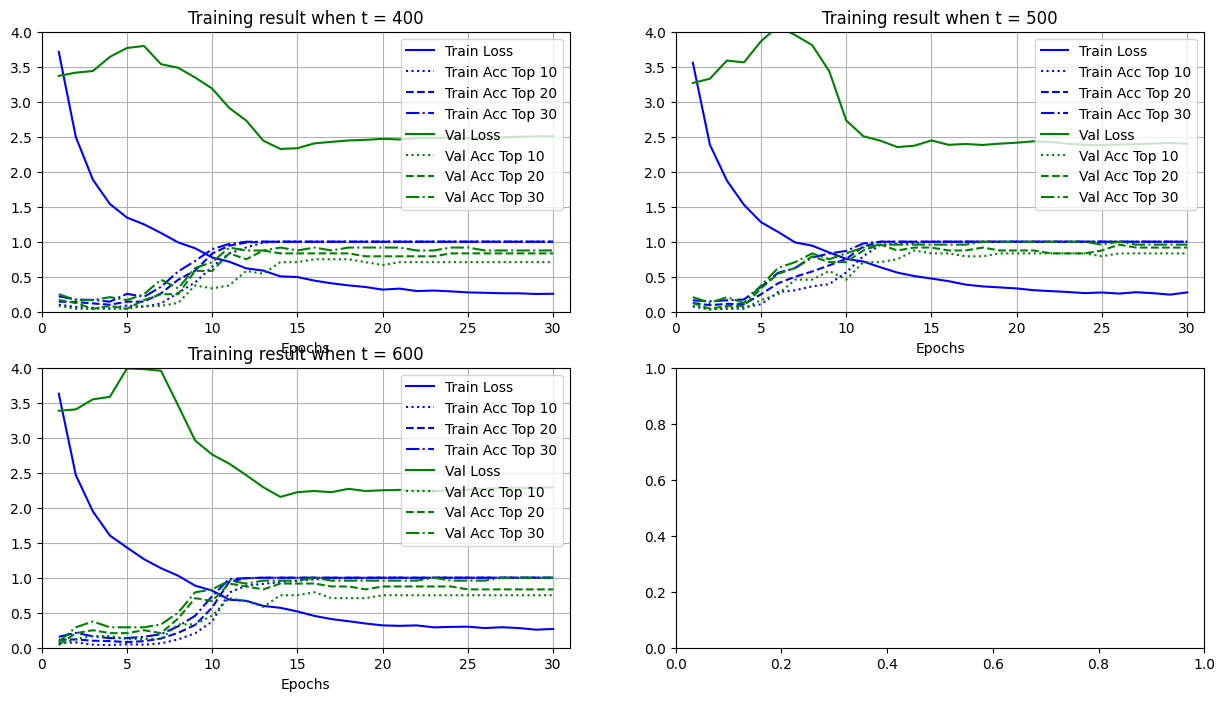

(400,) 10 mean 0.6812500000000001
(400,) 10 max 0.75
(400,) 20 mean 0.8208333333333334
(400,) 20 max 0.875
(400,) 30 mean 0.89375
(400,) 30 max 0.9166666666666666
(500,) 10 mean 0.8125
(500,) 10 max 0.875
(500,) 20 mean 0.8916666666666668
(500,) 20 max 0.9583333333333334
(500,) 30 mean 0.9729166666666664
(500,) 30 max 1.0
(600,) 10 mean 0.73125
(600,) 10 max 0.7916666666666666
(600,) 20 mean 0.8666666666666666
(600,) 20 max 0.9166666666666666
(600,) 30 mean 0.96875
(600,) 30 max 1.0


<Figure size 640x480 with 0 Axes>

In [17]:
draw_graph(train_metrics.data, 30, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')